# Qiskit & IBM Quantum Workshop



This tutorial was adapted from notebooks by: _Abby Mitchell - Quantum Developer Advocate (https://abbymitchell.dev) IBM Quantum_ and from _Kevin Sung - Qiskit Researcher, IBM Quantum_

# How to Use this Notebook in your IBM Quantum Lab Account



1. Go to http://ibm.biz/NUS2024 for the workshop resources

<img src="qr-code.png" width=300>

2. Click 'raw' button in GitHub, this will open the notebook file in a new tab

<img src="raw_button.png" width=600>

3. Right click on the raw file and save the file in jupyter notebook format (`.ipynb`)

<img src="save.png" width=600>

4. In IBM Quantum Lab, select upload button on in top left and upload the notebook file

<img src="upload_button.png" width=600>

5. If you didn't save it in `.ipynb` format you can rename the file in the jupyter lab

<img src="rename_button.png" width=600>

6. Now you can open the notebook in your IBM Quantum Lab environment! (note: if you want the images to display in your lab version you will need to download them from the github folder where the notebook is and upload it into your lab folder as well)

<img src="open_notebook.png" width=600>


# Goal: Show you the toolbox - Breadth, not depth!

# Qiskit overview: Main Packages



![](qiskit_overview.png)





# Qiskit 102: Learning to use Qiskit

The fundamental unit you will primarily work with in Qiskit is the `QuantumCircuit` object. The basic workflow to using Qiskit consists of two stages: build and execute. Building involves making different quantum circuits which represent the problem/algorithm you are solving. Executing takes care of the, well, *execution* of those circuits as a job or set of jobs to be run on either real or simulated hardware. After the jobs have been run, the data is collected and must be postprocessed depending on the desired output.  We can do most of this post-processing using Qiskit Runtime.

## Qiskit Runtime Overview
![](runtime-architecture.png)


Qiskit Runtime is a cloud-based quantum computing service developed by IBM. It offers computational primitives to perform foundational quantum computing tasks that use built-in error suppression and mitigation techniques. Primitives can be executed inside of sessions, allowing collections of circuits to be jointly run on a quantum computer without being interrupted by other users’ jobs. The combination of primitives, error suppression / mitigation, and sessions paves the way to efficiently build and execute scalable quantum applications.


---



## Getting Started

To install Qiskit and the Qiskit IBM Runtime (used to access IBM Quantum hardware), run the following commands:

```
pip install qiskit[visualization]
pip install qiskit-ibm-runtime
pip install qiskit-aer
```

The `[visualization]` suffix tells `pip` to install optional dependencies needed for Qiskit visualization functionality, such as drawing circuits with [Matplotlib](https://matplotlib.org/).

### Key concepts

## Primitives

Qiskit introduces abstractions called primitives for encapsulating the output of a quantum circuit. Currently, there are two primitives:
- **Sampler**: The output of the circuit is a (quasi-)probability distribution over measurement outcomes.
- **Estimator**: The output of the circuit is the expectation value of an observable, which must be provided in addition to the circuit.

Within Qiskit and the Qiskit Ecosystem, there are various concrete implementations of the primitives:
- Reference primitives included with [Qiskit](https://github.com/Qiskit/qiskit). These are useful for simulating the results of running small quantum circuits.
- Runtime primitives included with [Qiskit IBM Runtime](https://github.com/Qiskit/qiskit-ibm-runtime). These primitives are backed by real IBM Quantum hardware.
- Primitives in [Qiskit Aer](https://github.com/Qiskit/qiskit-aer). These primitives are backed by a high-performance quantum circuit simulator, and can handle larger circuits than the reference primitives and also model the effects of noise.

**Note:** The latest versions of the Qiskit SDK and Qiskit Runtime introduce version 2 of the primitives. Version 2 of the primitives have a different interface from version 1. While this Qiskit 102 session will use version 1, the next iteration of Qiskit 101 and 102 will use the version 2 primitives. You can visit https://docs.quantum.ibm.com/run/primitives#v2-primitives to see how the version 2 primitives from version 1.

We'll demonstrate the primitives using a small example circuit on two qubits.

# Time for some code! (finally!)

## Simple Examples:

## 0.1 Building the circuit 

The basic element needed for your first program is the QuantumCircuit. We begin by creating a QuantumCircuit comprised of two qubits.

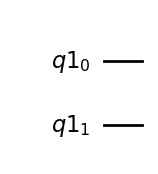

In [6]:
from qiskit import QuantumCircuit, QuantumRegister

# Initialize the qubits
qubits = QuantumRegister()

# Create the circuit
circuit = QuantumCircuit()

# Visualize circuit
circuit.draw("mpl")

## 0.2 Adding Gates

We can then add gates to the circuit. We start with a Hadamard gate acting on qubit $0$ and then add a $C_X$ (CNOT) gate using $0$ as the control qubit and $1$ as the target. 

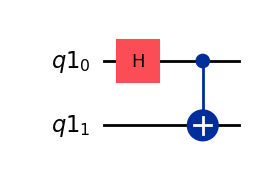

In [7]:
# Add a H gate on qubit 0, putting this qubit in superposition.


# Add a CX (CNOT) gate on control qubit 0 and target qubit 1, putting
# the qubits in a Bell state.


# Visualize circuit
circuit.draw("mpl")

## 0.3 Circuit Visualization

You can visualize your circuit using the `QuantumCircuit.draw()` method, which plots the circuit in the form found in many textbooks.

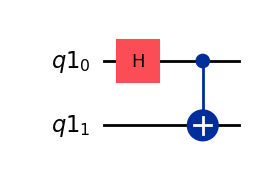

In [8]:
circuit.draw('mpl', style="iqp")

In [12]:
#One can also draw this as an ascii drawing
circuit.draw("text")

┌───┐     
q1_0: ┤ H ├──■──
      └───┘┌─┴─┐
q1_1: ─────┤ X ├
           └───┘


A few of the basic gates which can be added to a quantum circuit are the:

* Pauli $X$, $Y$, $Z$ gates - `.x()` `.y()`
* Hadamard $H$ gate 
* $S$ (or $\pi/2$) phase gate
* $T$ (or $\pi/4$) phase gate
* Controlled-NOT (or Controlled-$X$) gate - `.cx`
* Controlled-$H$ gate - `.ch`
* CCX or Toffoli gate - `.ccx`

among many others.  See [the documentation](https://docs.quantum.ibm.com/api/qiskit/circuit_library) for the full list of supported gates.

# 1.0 Using Primitives

There are two main approaches within Qiskit to execute and measure your quantum circuits called `Primitives`.  The first is the `Estimator` which computes the expectation values of observables.  Users generally specify a list of circuits, observables, and a few other optional configurations, with which the program can efficiently evaluate expectation values and variances.  The second is the `Sampler` primitive which with calculate the probabilities (or quasi-probabilities if using error mitigation) of bitstrings from quantum circuits.

Primitives work most effectively when they are supported by both Qiskit and the backend provider. The Qiskit module qiskit.primitives provides the required support on the Qiskit side, and providers like IBM Qiskit Runtime enable access to appropriate backends through native implementations of their own primitives.

We'll learn to use these objects by utilizing a small example circuit which will fully entangle two qubits together and then measure them.

 we'll demonstrate using the `Sampler` primitive (both the `qiskit.primitives` version as well as the managed `qiskit-ibm-runtime` version).  Recall the `Sampler` is primarily useful for when you want to measure (quasi-)probability distributions.  We'll use the same quantum circuit, `qc` which prepares a Bell state (i.e., fully entangle two-qubits together).


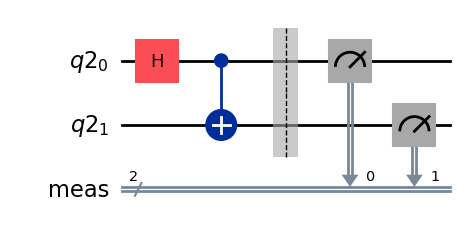

In [13]:
# Initialize the qubits
qubits = QuantumRegister(2)

# Create the circuit
circuit = QuantumCircuit(qubits)

# Unpack the qubits
q0, q1 = qubits

# Add the Hadamard and CNOT gates to the circuit
circuit.h(q0)
circuit.cx(q0, q1)

# Measure both qubits
circuit.measure_all()
circuit.draw("mpl")

In [14]:
from qiskit_aer.primitives import Sampler

sampler = Sampler()

# Now run the job and examine the results
sampler_job = sampler.run(circuit)
result = sampler_job.result()
print(f"Job Result:\n>>> {result}")
print(f"  > Quasi-probability distribution (integer): {result.quasi_dists[0]}")
print(
    f"  > Quasi-probability distribution (bits): {result.quasi_dists[0].binary_probabilities(2)}"
)
print(f"  > Metadata: {result.metadata[0]}")

Job Result:
>>> SamplerResult(quasi_dists=[{3: 0.5068359375, 0: 0.4931640625}], metadata=[{'shots': 1024, 'simulator_metadata': {'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 8, 'parallel_shots': 1, 'sample_measure_time': 0.000910875, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'active_input_qubits': [0, 1], 'device': 'CPU', 'time_taken': 0.003322083, 'measure_sampling': True, 'num_clbits': 2, 'max_memory_mb': 16384, 'input_qubit_map': [[1, 1], [0, 0]], 'num_qubits': 2, 'method': 'stabilizer', 'required_memory_mb': 0, 'fusion': {'enabled': False}}}])
  > Quasi-probability distribution (integer): {3: 0.5068359375, 0: 0.4931640625}
  > Quasi-probability distribution (bits): {'11': 0.5068359375, '00': 0.4931640625}
  > Metadata: {'shots': 1024, 'simulator_metadata': {'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 8, 'parallel_shots': 1, 'sample_measure_time': 0.000910875, 'noise': 'idea

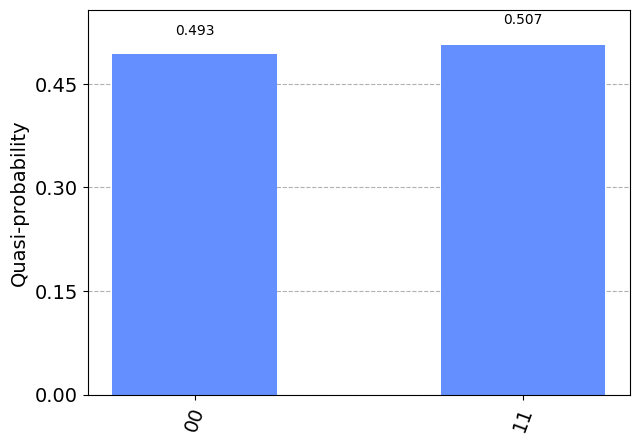

In [16]:
from qiskit.visualization import plot_distribution

prob_distribution = sampler_job.result().quasi_dists[0].binary_probabilities()

plot_distribution(prob_distribution)


---


Next we'll use the Runtime Sampler to run our circuit on a backend.  Recall that we still need to specify an `IBMBackend` object through the `QisktiRuntimeService`.

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

################# MAKE SURE YOUR API TOKEN IS SAVED ##########################

# Store your API token locally (only need to do once)
# QiskitRuntimeService.save_account(channel='ibm_quantum', token='$API_TOKEN')

##############################################################################

# Initialize a QiskitRuntimeService object
service = QiskitRuntimeService()

# Print the available backends
print("Available backends:")
for backend in service.backends():
    print(backend.name)

In [ ]:
backend = service.get_backend("ibm_nazca")


# Here we can get some status information about the backend
status = backend.status()
is_operational = status.operational
jobs_in_queue = status.pending_jobs
print("Operational?: {} \n Jobs in Queue: {}\n".format(is_operational, jobs_in_queue))


# We can also obtain some configuration information
config = backend.configuration()
print(
    64 * "#",
    "\nConfiguration for: {}, version: {}".format(
        config.backend_name, config.backend_version
    ),
)
print("  Number of Qubits: {}".format(config.n_qubits))
print("  Basis Gates: {}".format(config.basis_gates))
print("  OpenPulse Enabled: {}".format(config.open_pulse))

Now we'll run our job on hardware.  However first we must ensure that this circuit is written in terms of the *Instruction Set Architecture* (ISA) of the backend.  This essentially means the circuit must be written in terms of the available basis gates of the backend we will submit to.

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Create a staged pass manager which will translate the circuit in terms of the basis gates of the backend
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
transpiled_circuit = pm.run(circuit)

transpiled_circuit.draw('mpl', idle_wires=False)


In [114]:
# This import overwrites our previous Sampler import
from qiskit_ibm_runtime import SamplerV2 as Sampler, Session

# Use a runtime session to reduce time spent waiting in the queue
with Session(service=service, backend=backend):
    sampler = Sampler()
    job = sampler.run([(transpiled_circuit, )])
    print(f">>> Job ID: {job.job_id()}")
    print(f">>> Session ID: {job.session_id}")
    print(f">>> Job Status: {job.status()}")

base_primitive._run_primitive:INFO:2023-12-15 04:20:41,608: Submitting job using options {'optimization_level': 3, 'resilience_level': 1, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 3}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 1}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


>>> Job ID: cnxx86gbtqp000871keg
>>> Session ID: cnxx86gbtqp000871keg
>>> Job Status: JobStatus.QUEUED


We can also obtain a previous result as so.

In [115]:
# Use a job id from a previous result
job = service.job("cnxx86gbtqp000871keg")
print(f">>> Job Status: {job.status()}")

>>> Job Status: JobStatus.DONE


In [116]:
result = job.result()
print(f"Job Result:\n>>> {result}")
print(f"  > Quasi-probability distribution (integer): {result.quasi_dists[0]}")
print(f"  > Quasi-probability distribution (bits): {result.quasi_dists[0].binary_probabilities(2)}")
print(f"  > Metadata: {result.metadata[0]}")

Job Result:
>>> SamplerResult(quasi_dists=[{0: 0.5967178646963287, 1: -0.0360676025620483, 2: -0.044060158876869385, 3: 0.483409896742589}], metadata=[{'shots': 4000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.9860579541460641, 'readout_mitigation_time': 0.010091734118759632, 'warning': 'Optimization level clipped from 3 to 1'}])
  > Quasi-probability distribution (integer): {0: 0.5967178646963287, 1: -0.0360676025620483, 2: -0.044060158876869385, 3: 0.483409896742589}
  > Quasi-probability distribution (bits): {'00': 0.5967178646963287, '01': -0.0360676025620483, '10': -0.044060158876869385, '11': 0.483409896742589}
  > Metadata: {'shots': 4000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.9860579541460641, 'readout_mitigation_time': 0.010091734118759632, 'warning': 'Optimization level clipped from 3 to 1'}


We're also able to visualize the probability distribution of this circuit on a histogram.  Plotting this gives us a quick visual tool to help us understand what the states with the highest measurement probability are. 

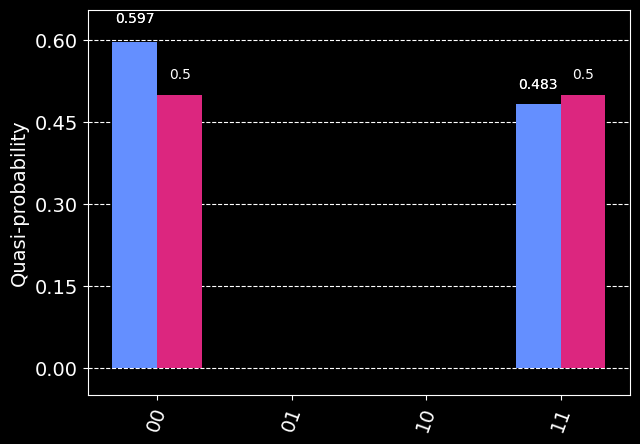

In [118]:
from qiskit.visualization import plot_distribution

import matplotlib.pyplot as plt
plt.style.use('dark_background')

#plot_distribution(result.quasi_dists[0])
plot_distribution([result.quasi_dists[0].binary_probabilities(2),prob_distribution])

## 1.1 The Estimator Primitive


Let's begin with understanding how to use the `Estimator` primitive.  To start, we'll need to define the observable(s) we want to measure the expectation values of.  The observable is a quantum operator that can be represented using one of several classes from the `qiskit.quantum_info` module.  For this example we'll use a `SparsePauliOp` object to represent the observable $\langle II +XX -YY + ZZ\rangle$.

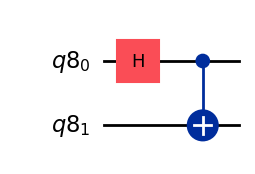

In [19]:
from qiskit import QuantumCircuit, QuantumRegister

# Initialize the qubits
qubits = QuantumRegister(2)

# Create the circuit
circuit = QuantumCircuit(qubits)

# Unpack the qubits
q0, q1 = qubits

# Add the Hadamard and CNOT gates to the circuit
circuit.h(q0)
circuit.cx(q0, q1)

circuit.draw("mpl")

In [20]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(["II", "XX", "YY", "ZZ"], coeffs=[1, 1, -1, 1])

Let's measure this observable using the reference Estimator primitive using the simulation package, `qiskit-aer`.

In [21]:
from qiskit_aer.primitives import Estimator

estimator = Estimator()

job = estimator.run(circuit, observable)
result = job.result()
print(result)
print(f"Expectation Value of <II+XX-YY+ZZ> = {result.values[0]:.3f}")

EstimatorResult(values=array([4.]), metadata=[{'shots': 1024, 'variance': 0.0, 'simulator_metadata': [{'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 8, 'parallel_shots': 1, 'sample_measure_time': 0.000845, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'active_input_qubits': [0, 1], 'device': 'CPU', 'time_taken': 0.001807542, 'measure_sampling': True, 'num_clbits': 2, 'max_memory_mb': 16384, 'input_qubit_map': [[1, 1], [0, 0]], 'num_qubits': 2, 'method': 'stabilizer', 'required_memory_mb': 0, 'fusion': {'enabled': False}}, {'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 8, 'parallel_shots': 1, 'sample_measure_time': 0.000612958, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'active_input_qubits': [0, 1], 'device': 'CPU', 'time_taken': 0.002883458, 'measure_sampling': True, 'num_clbits': 2, 'max_memory_mb': 16384, 'input_qubit_map': [[1, 1], [0, 0]], 'n

### 1.1.1 Using the Runtime Estimator

A subtle difference here is that there are actually *two* `Estimator` objects in our environment.  One within `qiskit.primitives` and one within our ecosystem package `qiskit-ibm-runtime`.  The Runtime Primitives are best used for submitting jobs to a backend while the Qiskit Primitives are useful for doing sanity checks on your workflows and ensuring everything is working as intended.

We'll now execute this circuit using the Runtime Service.  To do so, we'll need to initialize a `QiskitRuntimeService` object and select a backend to run the circuit on.  For this example we'll use the 127-qubit `ibm_nazca` backend.  We'll then instantiate a new `Estimator` object from the Runtime package. We have two options here: we can instantiate the `Estimator` object with the `backend`, *or* we can start a `Session` that we can send multiple jobs to without waiting in the queue for subsequent jobs, and pass the `Session` object to the `Estimator`.



In [55]:
from qiskit_ibm_runtime import QiskitRuntimeService

################# MAKE SURE YOUR API TOKEN IS SAVED ##########################

# Store your API token locally (only need to do once)
# QiskitRuntimeService.save_account(channel='ibm_quantum', token='$API_TOKEN')

##############################################################################

# Initialize a QiskitRuntimeService object
service = QiskitRuntimeService()

# Print the available backends
print("Available backends:")
for backend in service.backends():
    print(backend.name)

The access your institution has obtained will determine which backends are available to you.  You can list all of your available backends and obtain information about its status, the number of pending jobs, and detailed configuration information.

In [56]:
backend = service.get_backend("ibm_nazca")


# Here we can get some status information about the backend
status = backend.status()
is_operational = status.operational
jobs_in_queue = status.pending_jobs
print("Operational?: {} \n Jobs in Queue: {}\n".format(is_operational, jobs_in_queue))


# We can also obtain some configuration information
config = backend.configuration()
print(
    64 * "#",
    "\nConfiguration for: {}, version: {}".format(
        config.backend_name, config.backend_version
    ),
)
print("  Number of Qubits: {}".format(config.n_qubits))
print("  Basis Gates: {}".format(config.basis_gates))
print("  OpenPulse Enabled: {}".format(config.open_pulse))

Operational?: True 
 Jobs in Queue: 1

################################################################ 
Configuration for: ibm_torino, version: 1.0.1
  Number of Qubits: 133
  Basis Gates: ['cz', 'id', 'rz', 'sx', 'x']
  OpenPulse Enabled: True


Now we'll run our job on hardware.  However first we must ensure that this circuit is written in terms of the *Instruction Set Architecture* (ISA) of the backend.  This essentially means the circuit must be written in terms of the available basis gates of the backend we will submit to.

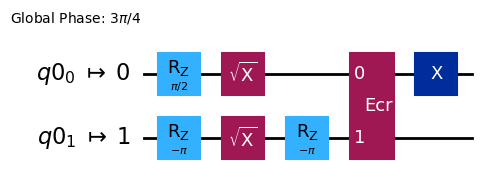

In [6]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Create a staged pass manager which will translate the circuit in terms of the basis gates of the backend
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
transpiled_circuit = pm.run(circuit)

transpiled_circuit.draw('mpl', idle_wires=False)


We also have to ensure that the observable respects the layout of the circuit (i.e. the arrangement of hardware qubits we'll use).  This can be done using the `apply_layout()` method.

In [7]:
# Get the qubit layout from the transpiled circuit
layout = transpiled_circuit.layout

# Ensure the observables are formatted to respect this layout.  This will insert Identity gates on qubits where no expectation value is specified
observables = observable.apply_layout(layout)
# observables = [ [observable.apply_layout(layout) for observable in observable_set] for observable_set in observable   ]
print(observables)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXX', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIYY', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ'],
              coeffs=[ 1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j])


We'll then instantiate a new runtime session to run this circuit.  The `Session` object allows us to group together a collection of iterative calls to the quantum computer and is started once the first job within the session is executed.  Subsequent jobs will then be prioritized in the queue.

Additionally, the `EstimatorV2` primitive takes its input in the form of a list of tuples containing a circuit, observables, and (optionally) parameters.  Each tuple is called as *Primitive Unitary Bloc* (PUB) and allows you to sweep across observables, parameters, and circuits in an efficient, vectorized way. 

In [8]:
# This import overwrites our previous Estimator import
from qiskit_ibm_runtime import EstimatorV2 as Estimator, Session

# Use a runtime session to reduce time spent waiting in the queue
with Session(service=service, backend=backend):
    estimator = Estimator()
    job = estimator.run([(transpiled_circuit, observables )])
    
    print(f">>> Job ID: {job.job_id()}")
    print(f">>> Session ID: {job.session_id}")
    print(f">>> Job Status: {job.status()}")

>>> Job ID: cqsj19n88ev0008109s0
>>> Session ID: cqsj19d88ev0008109rg
>>> Job Status: QUEUED


We can also check on the status on the online platform: [https://quantum.ibm.com/jobs](https://quantum.ibm.com/jobs)

Another useful feature is to be able to pull data from previous jobs you've run if you're running analysis on your results in a separate notebook or python script.  All that's needed is the Job ID

In [45]:
# Use a job id from a previous result
job = service.job("cqr7pq2ypz8g00805b90") # You'll change this to your particular Job ID you'd like to examine
print(f">>> Job Status: {job.status()}")

>>> Job Status: JobStatus.DONE


The results are returned in the form of a `PrimitiveResult` object, which contains a list of `PubResults` for each of the individual tuples (i.e. PUBs) used when `estimator.run()` was called.  Each `PubResult` can be accessed by its index and contains information about the expectation values, standard deviation, and standard error.

In [59]:
# Examine our results once the job has completed
result = job.result()
print(f">>> {result} \n \n", 32*"#", "\n")
print(f" >>  Expectation values:\n {result[0].data.evs} \n\n >> Standard Deviation: {result[0].data.stds} \n\n")
print(f">> Ensemble Error {result[0].data.ensemble_standard_error} ")
print('\n', 32*"#", '\n')
print(f" >>  Metadata:\n {result[0].metadata} \n\n")

>>> PrimitiveResult([PubResult(data=DataBin<4,1>(evs=[[1.        ]
 [1.02472527]
 [0.97582418]
 [1.03901099]], stds=[[0.        ]
 [0.014229  ]
 [0.01352639]
 [0.01285748]], ensemble_standard_error=[[0.        ]
 [0.01375821]
 [0.01415819]
 [0.01363537]]), metadata={'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {'twirled_readout_errors': [[23, 0.03564453125], [24, 0.02587890625]]}, 'num_randomizations': 32})], metadata={'twirling': {'enable_gates': False, 'enable_measure': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True}, 'version': 2}) 
 
 ################################ 

 >>  Expectation values:
 [[1.        ]
 [1.02472527]
 [0.97582418]
 [1.03901099]] 

 >> Standard Deviation: [[0.        ]
 [0.014229  ]
 [0.01352639]
 [0.01285748]] 


>> Ensemble Error [[0.        ]
 [0.01375821]
 [0.01415819]
 [0.01363537]] 

 ################################ 

 >>  Metadata:
 {'shots': 4096, 'target_precision': 0.015625, 'circuit

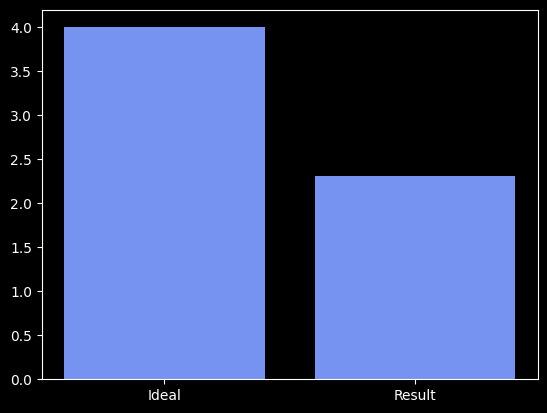

In [111]:
from qiskit.visualization import plot_histogram

import matplotlib.pyplot as plt
plt.style.use('dark_background')

data = {"Ideal": result_exact.values[0],"Result": result.values[0]}
plt.bar(range(len(data)), data.values(), align='center', color = "#7793f2")
plt.xticks(range(len(data)), list(data.keys()))

plt.show()

## 2. Transpilation & Error Mitigation

Oftentimes, the quantum circuits constructed for utility scale algorithms are not well optimized to run on noisy quantum hardware.  In fact, it may even be important to post-process your results using error mitigation techniques.  Fortunately, there are a few ways to implement both error mitigation as well as optimizations of your quantum circuits.

The first is to simply set a few Runtime configuration options; specifically the `optimization_level` and `resilience_level`.  These are both managed and included in a Runtime Primitive using the `Options` object.

The options for `optimization_level` are:

| Optimization Level | Estimator & Sampler |
| :--- | :--- |
| 0 | No optimization: typically used for hardware characterization or debugging <br />    - Basis translation <br /> - Layout (`TrivialLayout`: virtual -> physical)  <br /> - Routing: `StochasticSwap` |
| 1, 2, 3 | Light optimization: (TODO: update this w/ current docs) <br /> - Layout (trivial → vf2 → SabreLayout if routing is required) <br /> - Routing (SabreSwap if needed) <br /> - 1Q gate optimization <br /> - Error suppression: dynamical decoupling |


And the options for `resilience_level` are different between the `Sampler` and `Estimator` primitives

| Resilience Level | Definition | Estimator | Sampler |
| :--- | :--- | :--- | :---
|0 | No mitigation	| None | None |
|1 [Default] |	Minimal mitigation costs: Mitigate error associated with readout errors | Twirled Readout Error eXtinction (TREX interpreted-text readout errors )	| M3 |
| 2 | Medium mitigation costs. Typically reduces bias in estimators, but is not guaranteed to be zero bias. | Zero Noise Extrapolation (ZNE interpreted-text) |	- |
| 3| Heavy mitigation with layer sampling. Theoretically expected to deliver zero bias estimators. | Probabilistic Error cancelation (PEC interpreted-text)	| - |


Let's look at a quick example

In [23]:
from qiskit_ibm_runtime import Options

# To set our resilience and optimization level we need to create this `Options` object
options = Options()
options.resilience_level = 2

In [61]:
# We'll prepare the same example circuit as before
qubits = QuantumRegister(2)
circuit = QuantumCircuit(qubits)
q0, q1 = qubits
circuit.h(q0)
circuit.cx(q0, q1)

# and use the same observable as before
observable = SparsePauliOp(["II", "XX", "YY", "ZZ"], coeffs=[1, 1, -1, 1])

# Create a staged pass manager which will translate the circuit in terms of the basis gates of the backend
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
transpiled_circuit = pm.run(circuit)

transpiled_circuit.draw('mpl', idle_wires=False)


# Get the qubit layout from the transpiled circuit
layout = transpiled_circuit.layout

# Ensure the observables are formatted to respect this layout.  This will insert Identity gates on qubits where no expectation value is specified
observables = observable.apply_layout(layout)
# observables = [ [observable.apply_layout(layout) for observable in observable_set] for observable_set in observable   ]
print(observables)

In [62]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator

with Session(service=service, backend=backend):
    estimator = Estimator()
    estimator.options.optimization_level = 1
    estimator.options.resilience_level = 2
    job = estimator.run([(transpiled_circuit, observables)])
    print(f">>> Job ID: {job.job_id()}")
    print(f">>> Session ID: {job.session_id}")
    print(f">>> Job Status: {job.status()}")

base_primitive._run_primitive:INFO:2023-12-15 03:59:45,785: Submitting job using options {'optimization_level': 3, 'resilience_level': 2, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 3}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 2}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


>>> Job ID: cnxwychmbjng0081zj50
>>> Session ID: cnxwybhja3gg0085f6f0
>>> Job Status: JobStatus.QUEUED


In [63]:
# Use a job id from a previous result
job = service.job("cnxwx04ja3gg0085f6cg")
print(f">>> Job Status: {job.status()}")

>>> Job Status: JobStatus.DONE


In [64]:
#Examine our results once the job has completed
result_mitigated = job.result()
print(f">>> {result_mitigated}")
print(f"  > Expectation value: {result_mitigated.values[0]}")
print(f"  > Metadata: {result_mitigated.metadata[0]}")

>>> EstimatorResult(values=array([3.358375]), metadata=[{'zne': {'noise_amplification': {'noise_amplifier': "<TwoQubitAmplifier:{'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>", 'noise_factors': [1, 3, 5], 'values': [3.3285, 3.3125, 3.2439999999999998], 'variance': [1.18621975, 1.2111857499999998, 1.3032494999999997], 'shots': [4000, 4000, 4000]}, 'extrapolation': {'extrapolator': 'LinearExtrapolator'}}, 'warning': 'Optimization level clipped from 3 to 1'}])
  > Expectation value: 3.3583750000000023
  > Metadata: {'zne': {'noise_amplification': {'noise_amplifier': "<TwoQubitAmplifier:{'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>", 'noise_factors': [1, 3, 5], 'values': [3.3285, 3.3125, 3.2439999999999998], 'variance': [1.18621975, 1.2111857499999998, 1.3032494999999997], 'shots': [4000, 4000, 4000]}, 'extrapolation': {'extrapolator': 'LinearExtrapolator'}}, 'warning': 'Optimization 

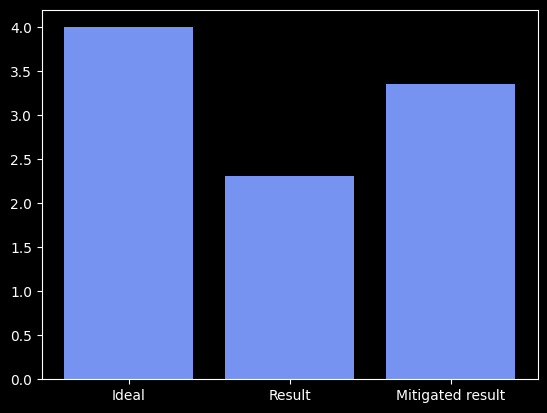

In [110]:
from qiskit.visualization import plot_histogram

import matplotlib.pyplot as plt
plt.style.use('dark_background')

data = {"Ideal": result_exact.values[0],"Result": result.values[0],"Mitigated result": result_mitigated.values[0]}
plt.bar(range(len(data)), data.values(), align='center', color = "#7793f2")
plt.xticks(range(len(data)), list(data.keys()))

plt.show()

In [52]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright

In [1]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright